## Denoising Autoencoder

In [1]:
from tensorflow.python.client import device_lib

In [3]:
import time
import math
import random
import os
import glob
from tqdm import tqdm
import natsort

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

from sklearn.metrics import confusion_matrix
from datetime import timedelta

import tensorflow.keras.layers as layers
import tensorflow.keras.models as models
from tensorflow.keras.initializers import orthogonal
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline
tf.__version__

'2.3.0'

In [3]:
#mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 텐서플로가 첫 번째 GPU만 사용하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작시에 접근 가능한 장치가 설정되어야만 합니다
        print(e)

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=7000)])
        tf.config.experimental.set_virtual_device_configuration(gpus[1],[tf.config.experimental.VirtualDeviceConfiguration(memory_limit=23000)])
    except RuntimeError as e:
        print(e)

### 1.1 Hyperparameters

### 1.1 Path

In [5]:
#train
clean_path = 'D:/Jupyter/Nahyoun/1. denoise/data/1. train/1. x_train_6000'
clean_files = natsort.natsorted(glob.glob(clean_path+'/*'))

noisy_path = 'D:/Jupyter/Nahyoun/1. denoise/data/1. train/3. x_train_noisy/1. dark'
noisy_files = natsort.natsorted(glob.glob(noisy_path+'/*'))

test_clean_path = 'D:/Jupyter/Nahyoun/1. denoise/data/2. inference/0. inference_image_1189'
test_clean_image_files = natsort.natsorted(glob.glob(test_clean_path+'/*'))
test_clean_files = natsort.natsorted(os.listdir(test_clean_path))

test_path = 'D:/Jupyter/Nahyoun/1. denoise/data/2. inference/3. inference_denosie/2. denoise_hazy_tolight'
test_image_files = natsort.natsorted(glob.glob(test_path+'/*'))
test_files = natsort.natsorted(os.listdir(test_path))
test_files_name = natsort.natsorted(test_files)

In [6]:
files_names = []
for i in range(len(test_files_name)):
    name = test_files_name[i].rstrip('.jpg')
    files_names.append(name)
print(files_names)

['6000', '6001', '6002', '6003', '6004', '6005', '6006', '6007', '6010', '6012', '6013', '6014', '6015', '6016', '6017', '6018', '6019', '6020', '6021', '6022', '6023', '6024', '6025', '6026', '6027', '6029', '6030', '6031', '6033', '6034', '6035', '6036', '6037', '6038', '6039', '6040', '6041', '6042', '6045', '6046', '6047', '6049', '6050', '6052', '6053', '6054', '6055', '6056', '6057', '6058', '6060', '6062', '6063', '6064', '6065', '6066', '6068', '6069', '6070', '6071', '6072', '6073', '6074', '6075', '6076', '6077', '6078', '6079', '6080', '6081', '6082', '6083', '6084', '6085', '6086', '6088', '6089', '6090', '6091', '6092', '6093', '6094', '6095', '6096', '6097', '6098', '6099', '6100', '6101', '6102', '6103', '6104', '6105', '6106', '6108', '6109', '6110', '6111', '6112', '6113', '6114', '6115', '6116', '6117', '6118', '6119', '6120', '6121', '6122', '6123', '6124', '6125', '6126', '6127', '6128', '6129', '6130', '6131', '6132', '6133', '6134', '6135', '6136', '6137', '6138',

### 1.2 Load data

In [8]:
# clean_train
clean_train = []
image_size = 256
for fl in tqdm(clean_files):
    try:
        image = cv2.imread(fl, cv2.IMREAD_COLOR)
        clean_train.append(image)
    except:
        break
clean_dataset = np.array(clean_train)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:08<00:00, 692.16it/s]


In [9]:
images = []
image_size = 256
for fl in tqdm(noisy_files):
    try:
        image = cv2.imread(fl)
        image = cv2.resize(image, (image_size, image_size), cv2.INTER_LINEAR)
        images.append(image)
    except:
        break
noisy_dataset = np.array(images)

100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 838.14it/s]


In [7]:
clean_X_test=[]
image_size = 256
for f in tqdm(test_clean_image_files):
    try:
        img = cv2.imread(f)
        img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)
        clean_X_test.append(img)
    except:
        break
clean_test_dataset = np.array(clean_X_test)

100%|█████████████████████████████████████████████████████████████████████████████| 1189/1189 [00:01<00:00, 860.66it/s]


In [8]:
X_test=[]
image_size = 256
for f in tqdm(test_image_files):
    try:
        img = cv2.imread(f)
        img = cv2.resize(img, (image_size, image_size), cv2.INTER_LINEAR)
        X_test.append(img)
    except:
        break
test_dataset = np.array(X_test)

100%|█████████████████████████████████████████████████████████████████████████████| 1189/1189 [00:01<00:00, 863.16it/s]


In [12]:
x_train = clean_dataset

In [13]:
x_train_noisy = noisy_dataset

In [9]:
x_test = test_dataset

In [10]:
x_test_clean = clean_test_dataset

In [11]:
#x_train = x_train.astype('float32') / 255.
#x_train_noisy = x_train_noisy.astype('float32') / 255.

x_test_clean = x_test_clean.astype('float32') / 255.

In [12]:
x_test =  x_test.astype('float32') / 255.

### 3.1 Model

In [10]:
def Conv2DLayer(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2D(filters, kernel_size=kernel, strides=strides, padding=padding,
                      kernel_initializer=kernel_init, name=prefix+'conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x

def Transpose_Conv2D(x, filters, kernel, strides, padding, block_id, kernel_init=orthogonal()):
    prefix = f'block_{block_id}_'
    x = layers.Conv2DTranspose(filters, kernel_size=kernel, strides=strides, padding=padding,
                               kernel_initializer=kernel_init, name=prefix+'de-conv')(x)
    x = layers.LeakyReLU(name=prefix+'lrelu')(x)
    x = layers.Dropout(0.2, name=prefix+'drop')((x))
    x = layers.BatchNormalization(name=prefix+'conv_bn')(x)
    return x



def AutoEncdoer(input_shape):
    inputs = layers.Input(shape=input_shape)
    
    conv1 = Conv2DLayer(inputs, 32, 3, strides=1, padding='same', block_id=1)
    conv2 = Conv2DLayer(conv1, 32, 3, strides=1, padding='same', block_id=2)

    conv3 = Conv2DLayer(conv2, 64, 3, strides=1, padding='same', block_id=3)
    conv4 = Conv2DLayer(conv3, 64, 3, strides=1, padding='same', block_id=4)
    
    conv5 = Conv2DLayer(conv4, 128, 3, strides=1, padding='same', block_id=5)
    conv6 = Conv2DLayer(conv5, 128, 3, strides=1, padding='same', block_id=6)
    
    conv7 = Conv2DLayer(conv6, 256, 3, strides=1, padding='same', block_id=7)
    
    deconv1 = Transpose_Conv2D(conv7, 256, 3, strides=1, padding='same', block_id=8)

    deconv2 = Transpose_Conv2D(deconv1, 128, 3, strides=1, padding='same', block_id=9)
    
    skip1 = layers.concatenate([deconv2, conv6], name='skip1')
    deconv3 = Transpose_Conv2D(skip1, 128, 3, strides=1, padding='same', block_id=10)
    
    skip2 = layers.concatenate([deconv3, conv5], name='skip2')
    deconv4 = Transpose_Conv2D(skip2, 64, 3, strides=1, padding='same', block_id=11)
    
    skip3 = layers.concatenate([deconv4, conv4], name='skip3')
    deconv5 = Transpose_Conv2D(skip3, 64, 3, strides=1, padding='same', block_id=12)
    
    skip4 = layers.concatenate([deconv5, conv3], name='skip4')
    deconv6 = Transpose_Conv2D(skip4, 32, 3, strides=1, padding='same', block_id=13)
    
    skip5 = layers.concatenate([deconv6, conv2], name='skip5')
    deconv7 = Transpose_Conv2D(skip5, 32, 3, strides=1, padding='same', block_id=14)
    
    conv10 = layers.Conv2D(3, 3, strides=1, padding='same', activation='sigmoid',
                       kernel_initializer=orthogonal(), name='final_conv')(deconv6)

    
    return models.Model(inputs=inputs, outputs=conv10)

In [11]:
input_shape = (256, 256)
model = AutoEncdoer((*input_shape, 3))
# model_opt = SGD(lr=0.005, decay=1-0.995, momentum=0.7, nesterov=False)
model_opt = Adam(lr=0.001)

model.compile(optimizer=model_opt, loss='mse', metrics=['accuracy'])

In [13]:
from tensorflow.keras.utils import plot_model

In [14]:
plot_model(model, to_file='model_shapes.png', show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [12]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block_1_conv (Conv2D)           (None, 256, 256, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
block_1_lrelu (LeakyReLU)       (None, 256, 256, 32) 0           block_1_conv[0][0]               
__________________________________________________________________________________________________
block_1_drop (Dropout)          (None, 256, 256, 32) 0           block_1_lrelu[0][0]              
_______________________________________________________________________________________

In [13]:
best_checkpoint_path = 'D:/Jupyter/Nahyoun/1. denoise/code/best_checkpoint/1. dark_train_checkpoint/cp-{epoch:04d}.ckpt'

cp_callback  = tf.keras.callbacks.ModelCheckpoint(
    best_checkpoint_path, monitor='val_loss', verbose=0, save_best_only=False,
    save_weights_only=True, mode='auto', save_freq='epoch')

In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [21]:
Hist = model.fit(x_train_noisy, x_train,
                 batch_size=1,
                 epochs=300,
                 shuffle=True,
                 validation_split = 0.2,
                 callbacks = [early_stopping, cp_callback])

Epoch 1/300
4800/4800 [==============================] - 344s 72ms/step - loss: 0.0110 - accuracy: 0.4705 - val_loss: 0.0048 - val_accuracy: 0.5211
Epoch 2/300
4800/4800 [==============================] - 344s 72ms/step - loss: 0.0067 - accuracy: 0.4967 - val_loss: 0.0050 - val_accuracy: 0.5201
Epoch 3/300
4800/4800 [==============================] - 343s 71ms/step - loss: 0.0060 - accuracy: 0.5021 - val_loss: 0.0114 - val_accuracy: 0.5206


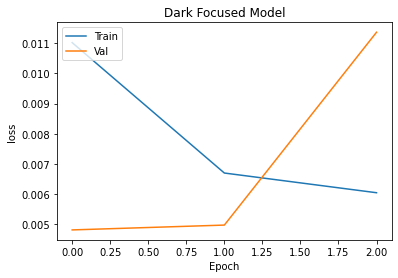

In [27]:
plt.plot(Hist.history['loss'])
plt.plot(Hist.history['val_loss'])

plt.title('Dark Focused Model')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [23]:
model.save_weights(best_checkpoint_path.format(epoch=1))

In [16]:
model = AutoEncdoer((*input_shape, 3))

In [18]:
best_checkpoint_path = 'D:/Jupyter/Nahyoun/1. denoise/code/best_checkpoint/1. dark_train_checkpoint/cp-0001.ckpt'
model.load_weights(best_checkpoint_path)

In [19]:
model.compile(optimizer=model_opt, loss='mse', metrics=['accuracy'])
score = model.evaluate(x_test, x_test_clean, verbose=1)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node functional_3/block_1_conv/Conv2D (defined at <ipython-input-19-9a9bbabda975>:2) ]] [Op:__inference_test_function_7692]

Function call stack:
test_function


In [ ]:
decoded_imgs = model.predict(x_train)

In [ ]:
number = 6

fig=plt.figure(figsize=(15, 5))

ax = plt.subplot(131)
plt.title('Original Image')
plt.imshow(x_train[number])

ax = plt.subplot(132)
plt.title('Noisy Image')
plt.imshow(x_train_noisy[number])

ax = plt.subplot(133)
plt.title('Denoised Image')
plt.imshow(decoded_imgs[number])
plt.show()

In [23]:
cleansed_imgs = model.predict(x_test_clean)

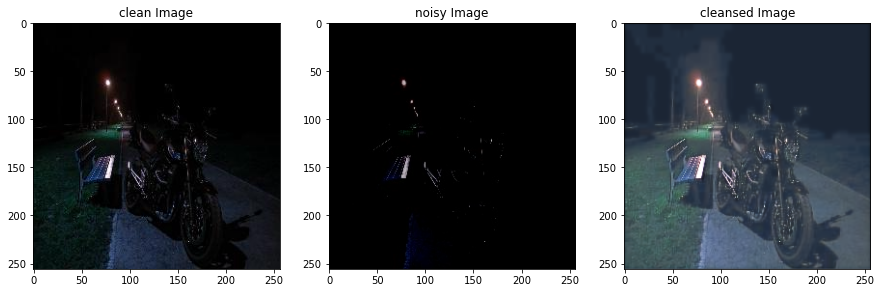

In [24]:
number = 60

fig=plt.figure(figsize=(15, 5))

ax = plt.subplot(131)
plt.title('clean Image')
plt.imshow(x_test_clean[number])

ax = plt.subplot(132)
plt.title('noisy Image')
plt.imshow(x_test[number])

ax = plt.subplot(133)
plt.title('cleansed Image')
plt.imshow(cleansed_imgs[number])

In [25]:
import cv2
path1 = 'D:/Jupyter/Nahyoun/1. denoise/data/2. inference/3. inference_denosie/13. inference_denoise_dark_l/'
for i in range(len(cleansed_imgs)):
    cv2.imwrite(path1+ files_names[i] +'.jpg', cleansed_imgs[i]*255)